# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import os
from shutil import copyfile

# Functions

In [2]:
def save_csv(data, csv_path, filename):
    data.to_csv(os.path.join(csv_path,filename), index=False)

def save_directory(data, target, input_path, output_path, n=None):
    for i, j in data.iterrows():    
        directory_name =  f"{os.path.basename(output_path)}-{target}-class_{data[target].nunique()}"
        if n: directory_name =  f"{directory_name}-n_{n}"     
        old_path = os.path.join(input_path, j.path)
        new_path = os.path.join(output_path, directory_name, eval(f"j.{target}"), j.title)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        copyfile(old_path,new_path)

    data["path"] = data[[target,"image"]].apply(lambda x: "/".join(x),axis=1)    

def get_sample(data, input_path, output_path, target='movement', 
               n=50, random_state=123, replace=False, 
               create_directory=False, create_csv=False): 
    
    datata_tmp = data.copy()
    
    if target == 'genre':
        datata_tmp.dropna(axis=0, subset=[target], inplace=True)
    
    sample = datata_tmp.groupby(by=target).sample(n=n, random_state=random_state, 
                                                  replace=replace)
    
    if create_directory:
        save_directory(sample, target, input_path, output_path,n=n)
    
    if create_csv:
        save_csv(sample, output_path, f"{os.path.basename(output_path)}-{target}-class_{sample[target].nunique()}-n_{n}.csv")
        
    return sample

def get_cs_class(csv_path, target):
    return pd.read_csv(os.path.join(csv_path,target + "_class.txt"), header=None, delim_whitespace=True)
    
def get_cs_train_val(csv_path, target, class_=None):
    
    if not isinstance(class_, pd.DataFrame):
        class_ = get_cs_class(csv_path, target)
        
    cs_train = pd.read_csv(os.path.join(csv_path, target + "_train.csv"), header=None)
    cs_train["split"] = "train"
    
    cs_val = pd.read_csv(os.path.join(csv_path, target + "_val.csv"), header=None)
    cs_val["split"] = "val"
    
    cs = pd.concat([cs_train, cs_val], ignore_index=True)
    cs.columns = ["path", target + "_id", "cs-split-" + target]
        
    cs[target] = cs[target + "_id"].apply(lambda x: class_.loc[x][1])
    cs["style-from-path"] = cs["path"].apply(lambda x: x.split('/')[0])
    cs["artist-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[0])
    cs["title-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[1])
    
    return cs

def get_data(csv_path, image_path, rm_duplicate=True, merge=None, create_csv=False,
             create_directory=False):
    '''
    Returns a complete dataframe containing all the information of all the files in 
    the wikiart dataset, as well as the genre labels and the train/val splits 
    of cs-chan

        Parameters:
            csv_path : string
                Path to the csv files of cs-chan
            image_path : string
                Path to the images of the wikiart dataset
            rm_duplicate : bool
                Remove a duplicata in the csv files of cs-chan
            merge : dict or None (default)
                merge one or more movements according to the parameters of the 
                "merge" dictionary: {"old_movement_name": "new_movement_name",}.
                If merge is None, no merger is carried out
            create_csv : bool
                If true, export the result of the get_data() function to a csv file
            create_directory : bool
                Create a new image directory with a new file architecture based on 
                the merge argument. If merge is "None", create_directory will be set to False

        Returns:
            data : pd.DataFrame
                Dataframe containing all the information of all the images in the wikiart dataset, as well as the genre labels and the train/val splits of cs-chan
    '''

    cs_style = get_cs_train_val(csv_path, 'style')
    cs_genre = get_cs_train_val(csv_path, 'genre')
    cs_artist = get_cs_train_val(csv_path, 'artist')

    # There is one duplicata inside genre_train.csv / genre_test.csv
    # One image labelled with two genres
    if rm_duplicate:
        if not cs_genre[cs_genre["path"].duplicated(keep='first')].empty:
            cs_genre.drop(cs_genre[cs_genre["path"].duplicated(keep='first')].index, 
                          inplace=True)
             
    movement_list = [i for i in os.listdir(image_path) 
                     if i != '.DS_Store']
    
    movement = []
    image = []
    artist = []
    title = []
    path = []
    
    for g in movement_list:
        files = os.listdir(os.path.join(image_path,g))
        movement.extend([g]*len(files))
        image.extend(files)
        artist.extend(list(map(lambda x: x.split('_')[0], files)))
        title.extend(list(map(lambda x: x.split('_')[1], files)))
        path.extend(list(map(lambda x: g + '/' + x, files)))
    
    data = pd.DataFrame({"path": path, "movement": movement, "artist": artist, "title": title, "image": image})
    
    data = data.merge(cs_genre[["path", "genre", "cs-split-genre"]], on="path",  how="outer")
    data = data.merge(cs_style[["path", "cs-split-style"]], on="path",  how="outer")
    data = data.merge(cs_artist[["path", "cs-split-artist"]], on="path",  how="outer")

    if merge:
        data["movement"] = data["movement"].apply(lambda x: merge.get(x,x))
        data["path"] = data[["movement","image"]].apply(lambda x: "/".join(x),axis=1)
    
    if merge and create_directory:
        print("create_directory: TO DO")
        
    if create_csv:
         save_csv(data, csv_path, f"{os.path.basename(csv_path)}-movement-class_{data['movement'].nunique()}.csv")
    
    return data

# Get Data

In [3]:
csv_path = "../raw_data/wikiart"
image_path= "../raw_data/wikiart/wikiart"
sample_path = "../raw_data/wikiart"

In [4]:
data = get_data(csv_path, image_path, create_csv=True)

In [6]:
data.head()

,path,movement,artist,title,image,genre,cs-split-genre,cs-split-style,cs-split-artist
0,Pointillism/henri-edmond-cross_chaine-des-maur...,Pointillism,henri-edmond-cross,chaine-des-maures-1907.jpg,henri-edmond-cross_chaine-des-maures-1907.jpg,landscape,train,train,NaN
1,Pointillism/theo-van-rysselberghe_fountain-at-...,Pointillism,theo-van-rysselberghe,fountain-at-san-souci-1903.jpg,theo-van-rysselberghe_fountain-at-san-souci-19...,cityscape,train,train,NaN
2,Pointillism/georges-seurat_the-away-samson-in-...,Pointillism,georges-seurat,the-away-samson-in-grandcamp-1885.jpg,georges-seurat_the-away-samson-in-grandcamp-18...,landscape,train,train,NaN
3,Pointillism/theo-van-rysselberghe_portrait-of-...,Pointillism,theo-van-rysselberghe,portrait-of-madame-charles-maus-1890.jpg,theo-van-rysselberghe_portrait-of-madame-charl...,portrait,train,train,NaN
4,Pointillism/jan-toorop_broek-in-waterland-1889...,Pointillism,jan-toorop,broek-in-waterland-1889.jpg,jan-toorop_broek-in-waterland-1889.jpg,landscape,train,train,NaN


In [7]:
sample = get_sample(data, image_path, sample_path, target='movement', n=6, random_state=123, 
                    replace=False, create_directory=True, create_csv=True)    


In [8]:
sample.head(1)

,path,movement,artist,title,image,genre,cs-split-genre,cs-split-style,cs-split-artist
58684,Abstract_Expressionism/mostafa-dashti_untitled...,Abstract_Expressionism,mostafa-dashti,untitled-2007.jpg,mostafa-dashti_untitled-2007.jpg,abstract_painting,train,train,NaN


In [10]:
merge = {"Abstract_Expressionism": "Abstract", 
         "Action_painting": "Abstract", 
         "Color_Field_Painting": "Abstract",
         "Synthetic_Cubism": "Cubism", 
         "Analytical_Cubism": "Cubism",
         "Rococo": "Baroque",
         "Early_Renaissance": "Renaissance",
         "High_Renaissance": "Renaissance",
         "Mannerism_Late_Renaissance": "Renaissance",
         "Northern_Renaissance": "Renaissance",
         "Post_Impressionism": "Impressionism",
         "Symbolism": "Impressionism"
        }

data_merge = get_data(csv_path, image_path, create_csv=True, merge=merge)

# Data Visualization

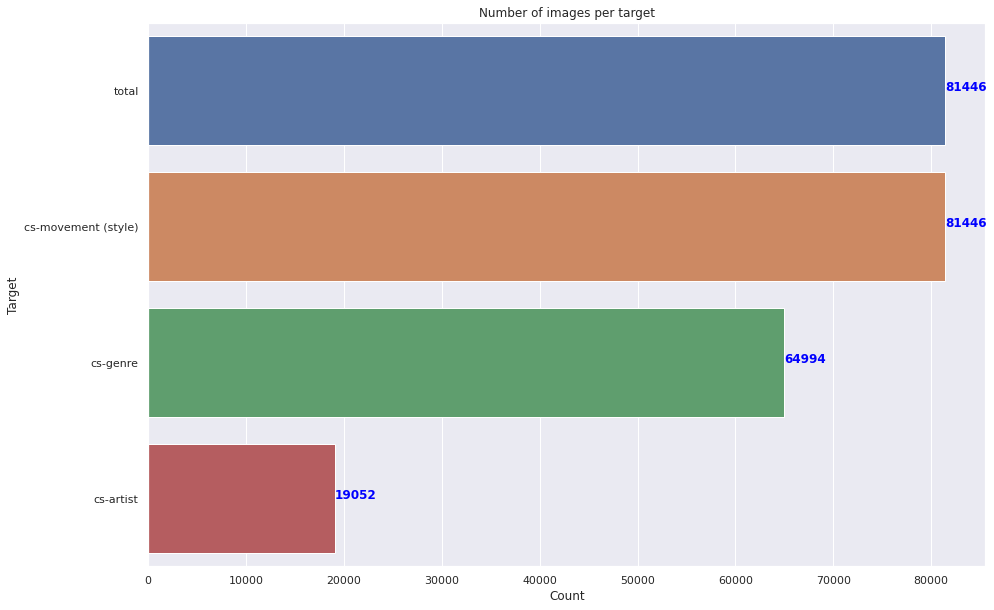

In [11]:
col = ['cs-split-artist','cs-split-genre','cs-split-style','path']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].count().index, 
            x=data[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].count().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax.set_title("Number of images per target");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

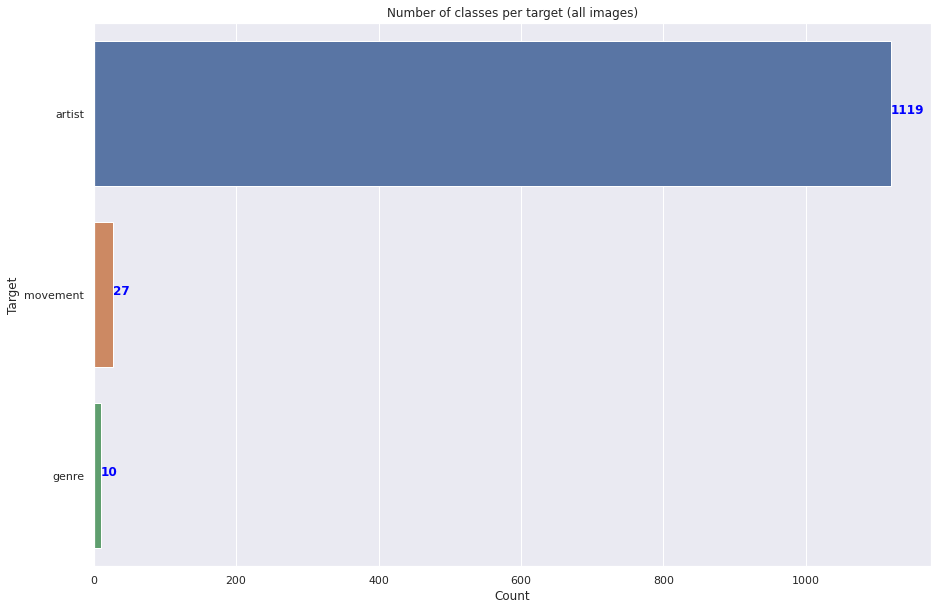

In [12]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of classes per target (all images)");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

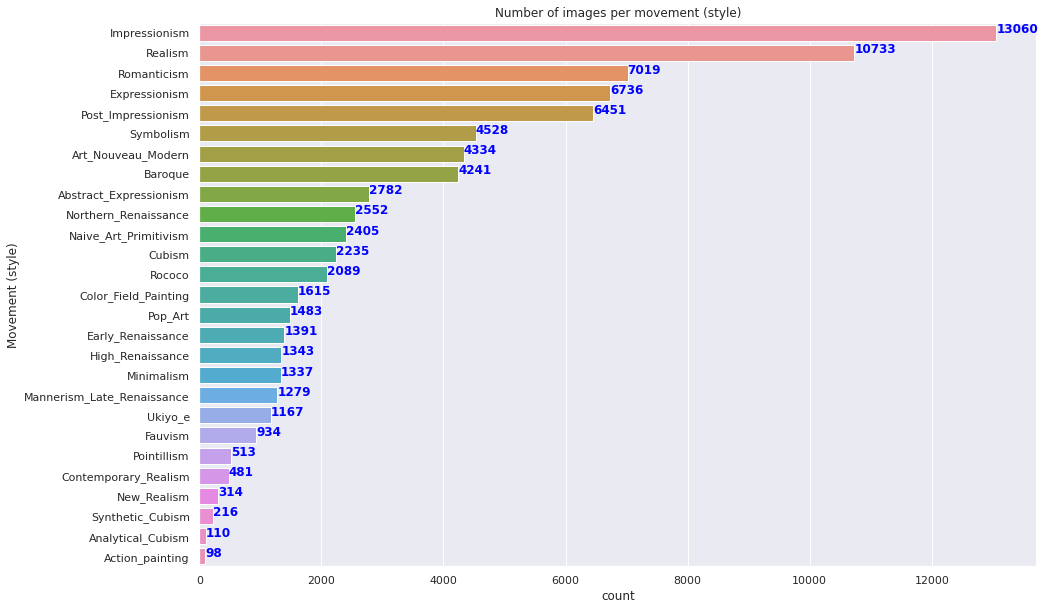

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per movement (style)");
ax.set_ylabel("Movement (style)");

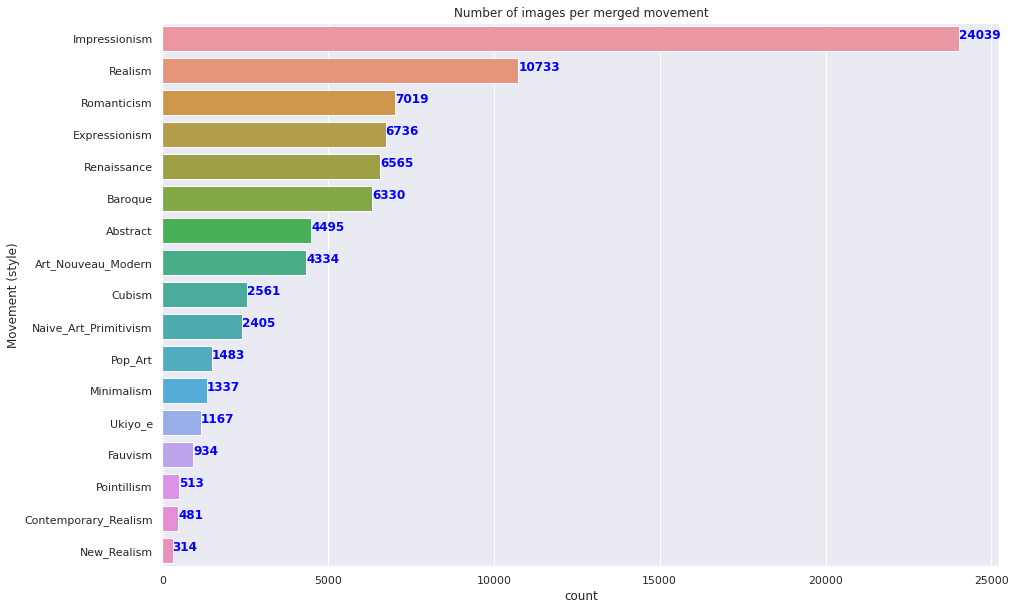

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data_merge, y="movement", 
              order = data_merge['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data_merge["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per merged movement");
ax.set_ylabel("Movement (style)");

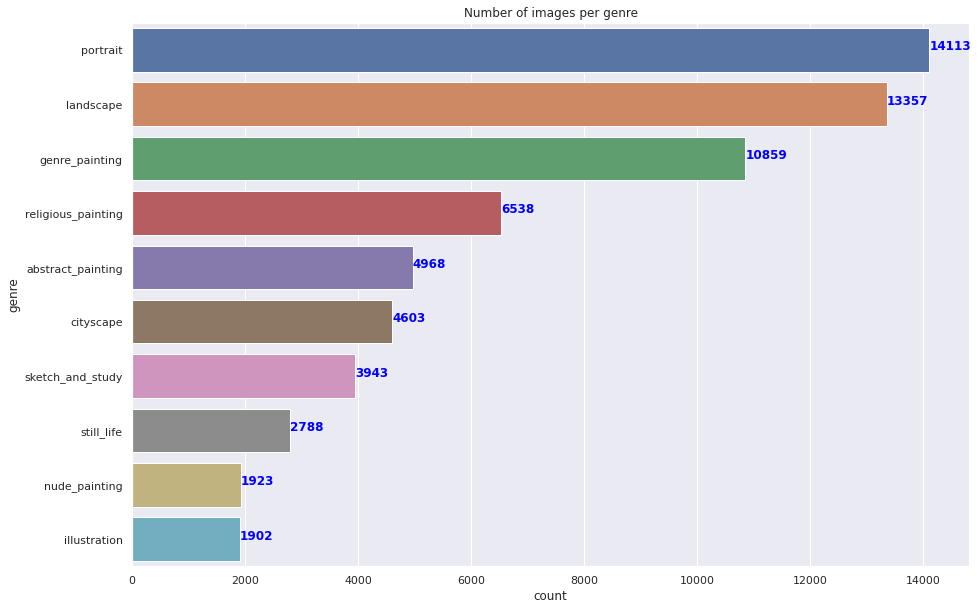

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["genre"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

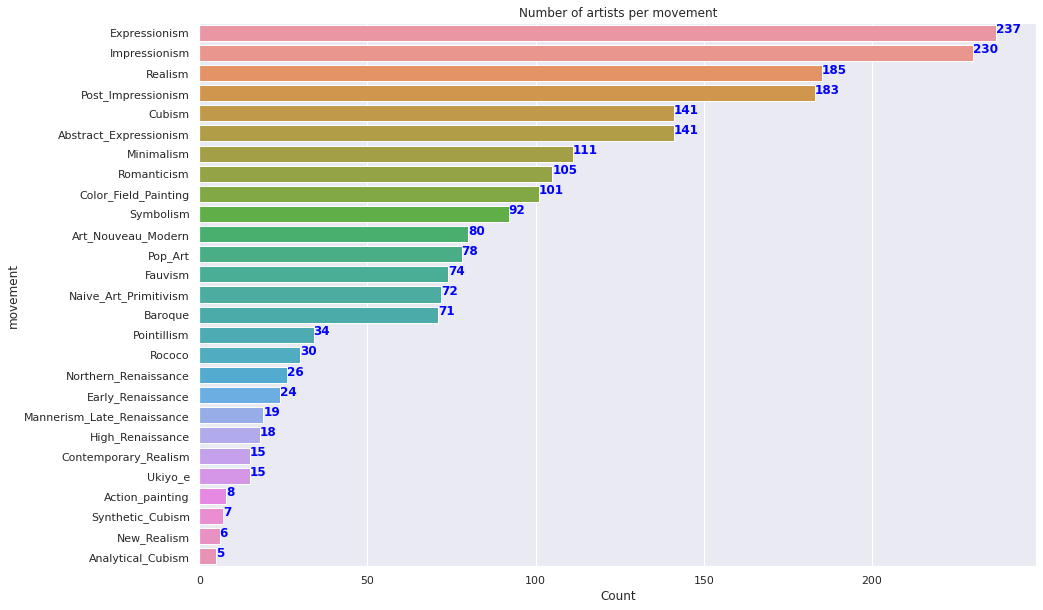

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");

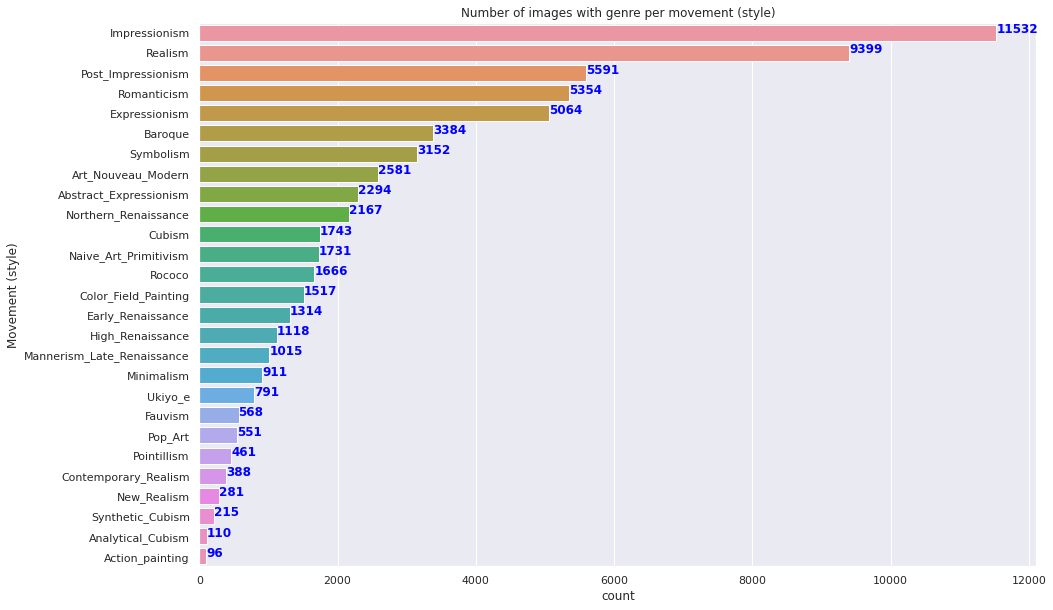

In [17]:
data2 = data[data["cs-split-genre"].notnull()]

fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data2, y="movement", 
              order = data2['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data2["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images with genre per movement (style)");
ax.set_ylabel("Movement (style)");

In [18]:
data[data["cs-split-genre"].notnull()][data["movement"]=="Abstract_Expressionism"].head(100)

/tmp/ipykernel_23872/574406601.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data["cs-split-genre"].notnull()][data["movement"]=="Abstract_Expressionism"].head(100)


,path,movement,artist,title,image,genre,cs-split-genre,cs-split-style,cs-split-artist
56964,Abstract_Expressionism/paul-jenkins_not_detect...,Abstract_Expressionism,paul-jenkins,not,paul-jenkins_not_detected_235713.jpg,abstract_painting,val,val,NaN
56965,Abstract_Expressionism/jackson-pollock_the-dee...,Abstract_Expressionism,jackson-pollock,the-deep-1953.jpg,jackson-pollock_the-deep-1953.jpg,abstract_painting,train,train,NaN
56969,Abstract_Expressionism/cy-twombly_quattro-stag...,Abstract_Expressionism,cy-twombly,quattro-stagioni-part-iv-inverno-1994.jpg,cy-twombly_quattro-stagioni-part-iv-inverno-19...,abstract_painting,train,train,NaN
56970,Abstract_Expressionism/richard-diebenkorn_mill...,Abstract_Expressionism,richard-diebenkorn,miller-22.jpg,richard-diebenkorn_miller-22.jpg,abstract_painting,train,train,NaN
56972,Abstract_Expressionism/richard-diebenkorn_berk...,Abstract_Expressionism,richard-diebenkorn,berkeley-no-58.jpg,richard-diebenkorn_berkeley-no-58.jpg,abstract_painting,train,train,NaN
...,...,...,...,...,...,...,...,...,...
57082,Abstract_Expressionism/brice-marden_distant-mu...,Abstract_Expressionism,brice-marden,distant-muses-2000.jpg,brice-marden_distant-muses-2000.jpg,abstract_painting,train,train,NaN
57083,Abstract_Expressionism/joan-miro_woman-in-fron...,Abstract_Expressionism,joan-miro,woman-in-front-of-the-sun-i.jpg,joan-miro_woman-in-front-of-the-sun-i.jpg,abstract_painting,train,train,NaN
57085,Abstract_Expressionism/atsuko-tanaka_untitled.jpg,Abstract_Expressionism,atsuko-tanaka,untitled.jpg,atsuko-tanaka_untitled.jpg,abstract_painting,train,train,NaN
57086,Abstract_Expressionism/julio-pomar_belle-isle-...,Abstract_Expressionism,julio-pomar,belle-isle-en-mer-1976.jpg,julio-pomar_belle-isle-en-mer-1976.jpg,abstract_painting,train,train,NaN


In [ ]:
def show_samples(df,sample_size=10):
    root_path='../raw_data/wikiart/wikiart/'
    artist=df['artist']
    movement=df['movement']
    title=df['title']
    folder_path=list(df['path'].sample(n=sample_size))
    complete_path=[root_path + i for i in folder_path]
    fig = plt.figure(constrained_layout=True,figsize=(10,5*sample_size))
    for i in list(range(0,sample_size)):
        plt.subplot(sample_size,1,i+1)
        image=plt.imread(complete_path[i])
        label=f'{movement[i]} - {title[i]} by {artist[i]}'
        plt.text(x=10,y=-2,s=label)
        plt.imshow(image)